# Finding Patterns in Data
## LSI and Scikit-Learn
    <Quin Daly>
    <Math 403>
    <10/12/2021>

In [11]:
import os
import string
import numpy as np
from math import log
from scipy import sparse
from sklearn import datasets
from scipy import linalg as la
from collections import Counter
from matplotlib import pyplot as plt
from scipy.sparse import linalg as spla
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Problem 1
- Perform PCA on the breast cancer dataset
- Graph the first two principal components
- Calculate the variance captured by the first two principal components

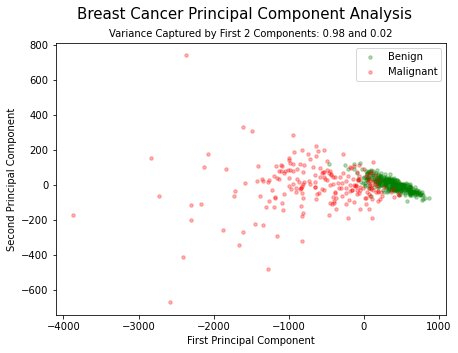

In [12]:
def prob1():
    """Recreate the plot in Figure 1 by performing 
    PCA on the breast cancer dataset.
    Include in the graph title the amount of variance
    captured by the first two principal components."""
    # Load the data
    cancer = datasets.load_breast_cancer()
    X = cancer.data
    y = cancer.target # Class labels (0 or 1)

    # Create the masks for plotting
    malignant_mask = (y==0)
    benign_mask = (y==1)

    # Pre-process X and perform SVD on it
    Y = X - X.mean(axis=0)
    U,S,Vt = la.svd(Y)
    Yhat = Y @ Vt.T[:,:2]

    # Calculate the variance captured by the first 2 principal components
    variance1 = round((S[0]**2)/(np.sum(S**2)),2)
    variance2 = round((S[1]**2)/(np.sum(S**2)),2)

    # Plot the malignant and benign for first 2 principal components
    plt.figure(figsize=(7,5))
    plt.scatter(Yhat[:,0][benign_mask], Yhat[:,1][benign_mask], color='green', alpha=0.3, s=12, label='Benign')
    plt.scatter(Yhat[:,0][malignant_mask], Yhat[:,1][malignant_mask], color='red', alpha=0.3, s=12, label='Malignant')
    plt.legend()
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.suptitle('Breast Cancer Principal Component Analysis',fontsize=15)
    plt.title('Variance Captured by First 2 Components: ' + str(variance1) + ' and ' + str(variance2), fontsize=10)
    
    return plt.show()

prob1()

## Problem 2
Implement the function similar()

In [128]:
def similar(i, Xhat):
    """
    Takes an index and matrix representing the principal components and returns the indices of
    the documents that are the most and least similar to i.
    
    Parameters:
    i index of a document
    Xhat decomposed data
    
    Returns:
    index_min: index of the document most similar to document i
    index_max: index of the document least similar to document i
    """
    # Iterate through the cols (documents) to find similar docs to doc i
    norms = []
    for j in range(Xhat.shape[0]):
        if j != i:
            norms.append(np.inner(Xhat[i,:], Xhat[j,:]) / la.norm(Xhat[i,:])*la.norm(Xhat[j,:]))
        if j == i:
            norms.append((norms[j-2]+norms[j-1])/2)
    index_min = np.argmax(norms)
    index_max = np.argmin(norms)
    
    return index_min, index_max

### Function for Problem 3

In [129]:
def document_converter():
    '''
    Converts speech documents into an n by m array where m is the number 
    of vocabulary words and n is the number of documents
    
    Returns:
    X sparse matrix (n x m): Each row represents a document
    paths (list): list where each element is a speech path eg: path[0] is './Addresses/1990-Bush.txt'
    '''
    # Get list of filepaths to each text file in the folder.
    folder = "./Addresses/"
    paths = [folder+p for p in os.listdir(folder) if p.endswith(".txt")]

    # Helper function to get list of words in a string.
    def extractWords(text):
        ignore = string.punctuation + string.digits
        cleaned = "".join([t for t in text.strip() if t not in ignore])
        return cleaned.lower().split()

    # Initialize vocab set, then read each file and add to the vocab set.
    vocab = set()
    for p in paths:
        with open(p, 'r', encoding="utf8") as infile:
            for line in infile:
                vocab.update(extractWords(line)) #union sets together


    # load stopwords
    with open("stopwords.txt", 'r',  encoding="utf8") as f:
        stops = set([w.strip().lower() for w in f.readlines()])

    # remove stopwords from vocabulary, create ordering
    vocab = {w:i for i, w in enumerate(vocab.difference(stops))}


    counts = []      # holds the entries of X
    doc_index = []   # holds the row index of X
    word_index = []  # holds the column index of X

    # Iterate through the documents.
    for doc, p in enumerate(paths):
        with open(p, 'r', encoding="utf8") as f:
            # Create the word counter.
            ctr = Counter()
            for line in f:
                ctr.update(extractWords(line))
            # Iterate through the word counter, store counts.
            for word, count in ctr.items():
                if word in vocab:
                    word_index.append(vocab[word])
                    counts.append(count)
                    doc_index.append(doc)

    # Create sparse matrix holding these word counts.
    X = sparse.csr_matrix((counts, [doc_index, word_index]),
                           shape=(len(paths), len(vocab)), dtype=np.float)
    return X, paths

## Problem 3
Use the function above and PCA to find speeches most and least similar to a given speech.

In [130]:
def prob3(speech, l=7):
    """
    Uses LSI, applied to the word count matrix X, with the first 7 principal
    components to find the most similar and least similar speeches

    Parameters:
        speech str: Path to speech eg: "./Addresses/1984-Reagan.txt"
        l (int): Number of principal components

    Returns:
        tuple of str: (Most similar speech, least similar speech)
    """    
    # Initialize data
    X, paths = document_converter()
    speech_index = paths.index(speech)
    
    # Pre-process X and perform SVD on it
    #Y = X - X.mean(axis=1)
    U,S,Vt = sparse.linalg.svds(X,k=l)
    Xhat = X @ Vt.T
    
    # Find most similar and least similar speeches to input speech
    most_similar, least_similar = similar(speech_index, Xhat)
    most = paths[most_similar][12:-4]
    least = paths[least_similar][12:-4]
    
    return (most, least)

In [131]:
#Run this box once you have written prob3()
speech = './Addresses/1984-Reagan.txt'
print(prob3(speech))

speech = "./Addresses/1993-Clinton.txt"
print(prob3(speech))

('1946-Truman', '1963-Johnson')
('1946-Truman', '1963-Johnson')


## Problem 4
Edit the end of the following function to return a weighted sparse matrix A.

In [165]:
def weighted_document_converter():
    '''
    Converts speech documents into an n by m array where m is the number 
    of vocabulary words and n is the number of documents. It gives weights
    to the most important words in the vocabulary.
    
    Returns:
    A (sparse matrix, n x m): Each row represents a document
    paths (list): list where each element is a speech path eg: path[0] is './Addresses/1990-Bush.txt'
    '''
    # Get list of filepaths to each text file in the folder.
    folder = "./Addresses/"
    paths = [folder+p for p in os.listdir(folder) if p.endswith(".txt")]

    # Helper function to get list of words in a string.
    def extractWords(text):
        ignore = string.punctuation + string.digits
        cleaned = "".join([t for t in text.strip() if t not in ignore])
        return cleaned.lower().split()

    # Initialize vocab set, then read each file and add to the vocab set.
    vocab = set()
    for p in paths:
        with open(p, 'r', encoding="utf8") as infile:
            for line in infile:
                vocab.update(extractWords(line)) #union sets together


    # load stopwords
    with open("stopwords.txt", 'r',  encoding="utf8") as f:
        stops = set([w.strip().lower() for w in f.readlines()])

    # remove stopwords from vocabulary, create ordering
    vocab = {w:i for i, w in enumerate(vocab.difference(stops))}

    t = np.zeros(len(vocab))
    counts = []      # holds the entries of X
    doc_index = []   # holds the row index of X
    word_index = []  # holds the column index of X

    # Iterate through the documents.
    for doc, p in enumerate(paths):
        with open(p, 'r', encoding="utf8") as f:
            # Create the word counter.
            ctr = Counter()
            for line in f:
                ctr.update(extractWords(line))
            # Iterate through the word counter, store counts.
            for word, count in ctr.items():
                if word in vocab:
                    word_ind = vocab[word]
                    word_index.append(word_ind)
                    #word_index.append(vocab[word])
                    counts.append(count)
                    doc_index.append(doc)
                    t[word_ind] += count
                    
    # get global weights
    #Problem 4
    # student work begins here
    for i, count in enumerate(counts):
        p = count
        
    # Create sparse matrix holding these word counts.
    A = sparse.csr_matrix((counts, [doc_index, word_index]),
                           shape=(len(paths), len(vocab)), dtype=np.float)
    
    
    return A, paths

## Problem 5
Use the weighted_document_converter() function above and scikit-learn's PCA to find speeches most and least similar to a given speech.

In [167]:
def prob5(speech, l=7):
    """
    Uses LSI, applied to the globally weighted word count matrix A, with the
    first 7 principal components to find the most similar and least similar speeches

    Parameters:
        speech str: Path to speech eg: "./Addresses/1984-Reagan.txt"
        l (int): Number of principal components

    Returns:
        tuple of str: (Most similar speech, least similar speech)
    """
    # Initialize data
    X, paths = document_converter()
    speech_index = paths.index(speech)
    
    # Pre-process X and perform SVD on it
    #Y = X - X.mean(axis=1)
    U,S,Vt = sparse.linalg.svds(X,k=l)
    Xhat = X @ Vt.T
    
    # Find most similar and least similar speeches to input speech
    most_similar, least_similar = similar(speech_index, Xhat)
    most = paths[most_similar][12:-4]
    least = paths[least_similar][12:-4]
    
    return (most, least)

In [168]:
#Run this box after you have completed prob5()
speech = './Addresses/1984-Reagan.txt'
print(prob5(speech))

speech = "./Addresses/1993-Clinton.txt"
print(prob5(speech))

('1946-Truman', '1963-Johnson')
('1946-Truman', '1963-Johnson')


## Problem 6
- Split the breast cancer dataset into training and testing sets using random_state=2
- Fit KNeighborsClassifier and RandomForestClassifier to the training data
- Predict labels for the testing set
- Print a classification_report for each classifier
- Write a few sentences explaining which classifier would be better to use in this situation and why

In [169]:
# Load the data to be used in next 3 problems
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target # Class labels (0 or 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=2)

In [170]:
# RandomForest Classifier
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
forest_predicted = forest.predict(X_test)

# KNeightbors Classifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_predicted = knn.predict(X_test)

Random Forest Classifier:

In [159]:
print(classification_report(y_test, forest_predicted))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        56
           1       0.95      0.95      0.95        87

    accuracy                           0.94       143
   macro avg       0.94      0.94      0.94       143
weighted avg       0.94      0.94      0.94       143



KNeighbors Classifier

In [160]:
print(classification_report(y_test, knn_predicted))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90        56
           1       0.93      0.94      0.94        87

    accuracy                           0.92       143
   macro avg       0.92      0.92      0.92       143
weighted avg       0.92      0.92      0.92       143



In [163]:
print('For this problem, recall would be most important since we want to know how many of the actual positives are predicted correctly. Therefore, the RandomForest Classifier would be best to use because it has higher recall for both benign and malgnant.')

For this problem, recall would be most important since we want to know how many of the actual positives are predicted correctly. Therefore, the RandomForest Classifier would be best to use because it has higher recall for both benign and malgnant.


## Problem 7
- Use the breast cancer dataset split from Problem 6
- Run a GridSearch with a RandomForestClassifier, modifying at least three parameters.
- Use scoring="f1"
- Print out best_params_ and best_score_
- Print a confusion matrix for the test data

In [161]:
# Create the classifier
forest = RandomForestClassifier()

# Specify vals for hyperparameters
param_grid = {
    'n_estimators':[200,700],
    'max_features':['auto','sqrt','log2'],
    'max_depth':[4,5,6]
}

# Create the grid, fit using train data, create confusion matrix
forest_gs = GridSearchCV(forest, param_grid, scoring='f1',n_jobs=-1)
forest_gs.fit(X_train, y_train)
forest_predicted = forest_gs.predict(X_test)
CM = confusion_matrix(y_test,forest_predicted)

print(forest_gs.best_params_,forest_gs.best_score_)
print(CM)

{'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 200} 0.9707055679532743
[[52  4]
 [ 4 83]]


## Problem 8
- Create a pipeline with a StandardScaler, PCA, and a KNeighborsClassifier
- Do a grid search, modifying at least 6 parameters
- Print your best parameters and best score (f1)
- Get a score of at least .96

In [164]:
# Create the pipeline, using Scaler, PCA, and KNN as classifiers
pipe = Pipeline([('scaler',StandardScaler()),
                ('pca',PCA()),
                ('knn',KNeighborsClassifier())])

# Create the grid
pipe_gs_dict = [{
    'scaler__with_mean':[True,False],
    'scaler__with_std':[True,False],
    'pca__n_components':[2,3,4,5],
    'pca__svd_solver':['auto','full'],
    'knn__weights':['uniform','distance'],
    'knn__algorithm':['ball_tree','kd_tree']
    
}]

# Fit using training data
pipe_gs = GridSearchCV(pipe, pipe_gs_dict, scoring='f1', n_jobs=-1).fit(X_train,y_train)
print('Best Classifier: ', pipe_gs.best_params_)
print('Best Score: ', pipe_gs.best_score_)

Best Classifier:  {'knn__algorithm': 'ball_tree', 'knn__weights': 'uniform', 'pca__n_components': 5, 'pca__svd_solver': 'auto', 'scaler__with_mean': True, 'scaler__with_std': True}
Best Score:  0.969106086904252
